# Projet informatique - Mazars
## BELAMRI Pierre
## PLANCHE Louis
## DEJOIE Antoine

Imports utiles 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import quad
from math import sqrt,log,exp,pi

1) Récupération et parsing des quotations d’options
Un jeu de données au format .csv sera fourni aux étudiants. Il contiendra des données de marché tel qu’observable sur le site https://www.barchart.com/options . Les étudiants développeront un parser, qui filtrera le fichier d’input pour en conserver seulement les données utiles. 


Le parser se trouve dans le fichier $ parser.py  $ et s'utilise par le terminal de la façon suivante :

- Ouvrir le terminal
- Se placer dans le répertoire contenant parser.py ainsi que le csv à trier.

*cd ~path/projet_mazars/*

- Appeler le programme en mettant en argument le nom du csv à trier, le symbole sur lequel on travaille, l'option (Call, Put ou Both par défaut pour les deux)

*python parser.py stocks-options.csv AAPL Call*

- Vous serez ensuite invité à saisir une valeur pour le DTE

*11*

- Pour cet exemple, le programme créer dans le même répertoire un fichier "stocks-options_extracterd_AAPL.csv" contenant seulement les lignes concernant Apple pour des options d'achats qui expirent dans 11 jours.

In [2]:
cd code

E:\GitHub\projet_mazars\code


Le programme fonctionne de la façon suivante: Les lignes du csv vont être lues une par une (*for row in spamreader*) jusqu'a ce que le symbol, le DTE et le choix de l'option correspondent avec notre choix (*if*) dans ce cas on balaie toute la ligne avec une boucle *for* et on créé un dictionnaire contenant toute cette ligne, on écrit ensuite ce dictionnaire dans un nouveau csv ( *writer.writerow(d)*)

In [3]:
spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')

for row in spamreader:
    A = list((",".join(row)).split(","))
    if A[0] == symbol  and A[5] == str(DTE) and (A[2] == choix) :
        d=dict()
        for j in range (len(A)):
            d[B[j]] = A[j] 
        writer.writerow(d)

NameError: name 'csv' is not defined

2) Développer un programme d’interpolation spline cubique


Pour cette partie nous avons développé une fonction capable de réaliser une interpolation spline cubique pour nimporte quel jeu de donnée, puis l'appliquer ensuite sur les volatilités implicites

Le code complet se trouve dans *interpolation_spline3.py*

Pour cela nous commençons par créer une fonction qui va intitialiser l'interpolation sur le jeu de donnée, via l'algorithme disponible sur https://fr.wikipedia.org/wiki/Spline#Spline_d%27interpolation

In [4]:
def init_spline(X,Y, F1=0 , Fn=0):
    n = len(X)
    h=[]
    F=[]
    h.append(X[1]-X[0])
    for i in range (1,len(X)-1):
        h.append(X[i+1]-X[i])
        F.append( (Y[i+1]-Y[i])/h[i] - ((Y[i]-Y[i-1])/h[i-1]) )
    F = [F1] + F +[Fn]

    X = np.array(X)
    Y = np.array(Y)
    h = np.array(h)
    F = np.array(F)
    R = np.zeros((n,n))
    
    R[0,0],R[n-1,n-1] = 1,1

    for i in range (1,n-1):
        R[i,i] = (h[i-1]+h[i])/3 #diagonale
        R[i,i+1] = h[i]/6 #diagonale superieure
        R[i,i-1] = h[i-1]/6 #diagonale inferieure
    
    invR = np.linalg.inv(R)
    M = np.dot(invR , F)
    C,Cprime = np.zeros(n-1),np.zeros(n-1)
    for i in range(n-1):
        C[i] = (Y[i+1]-Y[i])/h[i] - h[i]/6 * (M[i+1]-M[i])
        Cprime[i] = Y[i] - M[i]*(h[i]**2)/6
    
    #print(C)
    return M,h,C,Cprime


Ensuite, l'interpolation se réalise systématiquement à l'aide d'une classe, qui va prendre en argument le jeu de données et qui va retourner une selon l'option interpolated(x) une fonction de x points qui sera la fonction du jeu de donnée Y d'entrée mais interpolée ( continue donc )

In [5]:
class Spline:
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
        self.M , self.h , self.C , self.Cprime = init_spline(self.X,self.Y)
    def interpolated(self,x):
        k = 0
        while not(self.X[k] <= x <= self.X[k+1]) :
            k += 1
        y = self.M[k] * (self.X[k+1]-x)**3 / (6*self.h[k]) 
        y += self.M[k+1] * (x-self.X[k])**3 / (6*self.h[k])
        y += self.C[k] * (x - self.X[k])
        y += self.Cprime[k]

        return (y)
    
self.interpolated(K)

NameError: name 'self' is not defined

On a pu tester l'interpolation sur la fonction sinus ici :

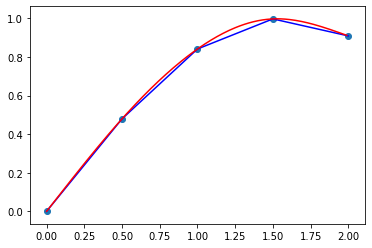

In [6]:
X = [0,0.5,1,1.5,2]
Y = [0,0.4794,0.8415,0.9975,0.9093]
Ybis =  [i for i in Y]
splinned = Spline(X,Y)


Xtest = list(np.arange(0,2,0.01))
Ytest = []
Y2 =[]
for x in Xtest:
    if x in X:
        y = Y.pop(0)
        Ytest.append(y)
        Y2.append(y)
    else :
        Ytest.append(splinned.interpolated(x))

  


plt.scatter(X,Ybis)
plt.plot(X,Ybis,'b')
plt.plot(Xtest,Ytest,'r')
plt.show()

En bleu il s'agit de quelques points de la fonction sinus (discrets donc) et en rouge le traçé de l'interpolation de ces points (fonction continue).

3) Implémenter la formule de Black-Scholes

Le code total pour implémenter la formule de Black-Scholes se trouve dans *BS.py*

Le prix théorique d'une option de vente est donné par :

$ P(S_{0} , K,r,T,\sigma) = - S_{0}. \mathcal{N} (-d_{1}) + K e^{-rT} \mathcal{N} (-d_{2}) $

où $ \mathcal{N} $ est la fonction de répartition de la loi normale centrée réduite

et ou 

$ d_1 = \frac{1}{\sigma \sqrt(T)} [ ln(\frac{S_{0}}{K})+(r   + \frac{1}{2} \sigma ^{2})T] $

et 

$ d_{2} = d_{1} - \sigma \sqrt{T} $

Les fonctions correspondantes en python sont les suivantes :

In [7]:
def Normale(x):
    return 1/sqrt(2*pi) * exp(-x**2/2)

def N(x):
    res = quad(Normale, -50,x)[0]    
    return res


def d1(S0,T,K,r,sigma):
    return 1/(sigma*sqrt(T)) *(log(S0/K)+T*(r+sigma**2/2))


def d2(S0,T,K,r,sigma):
    return d1(S0,T,K,r,sigma) - sigma * sqrt(T)


def Call(S0,T,K,r,sigma):
    C = S0 * N(d1(S0,T,K,r,sigma)) - K*exp(-r*T) * N(d2(S0,T,K,r,sigma))
    return C 

4) Impliciter la fonction de répartition

Pour cette partie nous avons du interpoler la fonction des

In [ ]:
class SYMBOL:
    def __init__(self,symbol,version=v1,csvname=None,dte=None,S0=None, r=0.0006):
        self.symbol = symbol
        if version == 'v1':
            self.S0 , self.T , self.K , self.IV , self.Volumes = recup(self.symbol)
        else:
            self.S0 , self.T , self.K , self.IV , self.Volumes = recup2(csvname,dte,S0)
        self.r = r  #OIS/USD
        
        self.K_,self.IV_ = TRI3(self.K,self.IV)
        i = 0
        while i <= len(self.K_)-2:
            while self.K_[i] == self.K_[i+1]:
                self.K_.pop(i)
                self.IV.pop(i)
            i += 1
        t = 0.2
        
        ####### Traitement sur la liquidité
        indexes = delete_indexes(self.Volumes,t,False)
        print(f"points supprimés car trop peu liquides pour {self.symbol} : ",len(indexes))
        self.K_ = TRI2(self.K_,indexes)
        self.IV_ = TRI2(self.IV_,indexes)
        self.Volumes_ = TRI2(self.Volumes,indexes)
        self.T_ = TRI2(self.T,indexes)
        self.S0_ = TRI2(self.S0,indexes)
        self.sigma = interpolation_spline3.Spline(self.K_,self.IV_) #Sigma est une fonction qui s'appelle par sigma.interpolated(k)
        ####### Fin traitement
        #recherche atm:
        self.atm_index = 0
        dist = abs(self.K_[self.atm_index] - self.S0_[self.atm_index])
        for j in range(len(self.K_)):
            if abs(self.K_[j] - self.S0_[j]) < dist:
                dist = abs(self.K_[self.atm_index] - self.S0_[self.atm_index])
                self.atm_index = j
        #fin recherche
        
        
    def F(self,i,s=None,k=None,t=None,iv=None ,epsilon = 10**-11): #fonction de répartition du sous jacent
        if s == None:
            s = self.S0_[i]
        if t == None:
            t = self.T_[i]
        if k == None:
            k = self.K_[i]
        if iv == None:
            iv1 = self.sigma.interpolated(k-epsilon/2)
            iv2 = self.sigma.interpolated(k+epsilon/2)
        else:
            iv1,iv2 = iv,iv
        yk1 = BS.Call(s,t,k-epsilon/2,self.r,iv1)
        yk2 = BS.Call(s,t,k+epsilon/2,self.r,iv2)
        
        D = -   (yk2 - yk1)/epsilon

        return D



In [ ]:
AAPL = SYMBOL("AAPL",'v2',"aapl-options-4.csv",4,358.87)
MSFT = SYMBOL("MSFT",'v2',"msft-options-3.csv",3,202.98)

In [ ]:
import sys
from main import SYMBOL




try:
    sys.argv.pop(0)
    symbol = sys.argv.pop(0)
    nom_fichier = sys.argv.pop(0)
    DTE = int(input('choisir la valeur du DTE (en jour): '))
    S0 = float(input('choisir la valeur actuelle du sous-jacent: '))
    #IV = float(input('choisir la valeur de la volatilité implicite: '))
    K = float(input('choisir la valeur du strike: '))


    Pricer = SYMBOL(symbol,'v2',nom_fichier,DTE,S0)
    proba=round(Pricer.F(s=S0,k=K,t=DTE/365),4)

    print(f'La probabilité de finir dans la monnaie à maturité est : {proba}')

except:
    print("Entrez les paramètres suivants: 'SYMBOL' 'fichier.csv' ")


